In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

In [2]:
import sys

sys.path.append("/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01")

### train, test data load

In [3]:
data_path = '../data/'
train_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'test.csv')
interest_rate = pd.read_csv(data_path + 'interestRate.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

In [4]:
total_data = pd.concat([train_data, test_data], axis=0)
min_lng = total_data['longitude'].min()
max_lng = total_data['longitude'].max()
min_lat = total_data['latitude'].min()
max_lat = total_data['latitude'].max()

### 공공시설 data load

In [5]:
file_names: List[str] = [
    f for f in os.listdir(data_path) if 'info' in f or 'Info' in f
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

file_dict.keys()

dict_keys(['schoolinfo', 'subwayInfo', 'parkInfo'])

In [6]:
for i, v in file_dict.items():
    df = v.copy()
    file_dict[i] = df[(min_lng <= df['longitude']) & (min_lat <= df['latitude']) & (df['longitude']<=max_lng) & (df['latitude']<=max_lat)]
    print(len(file_dict[i]))

4375
686
7370


In [7]:
train_data = train_data.merge(interest_rate, left_on='contract_year_month', right_on='year_month', how='left')
train_data.drop(columns=['year_month'], inplace=True)
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1.78
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,1.26
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,1.26
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1.68
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,4.00
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,4.00
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3.84
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3.84


In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
 11  interest_rate        float64
dtypes: float64(5), int64(7)
memory usage: 164.9 MB


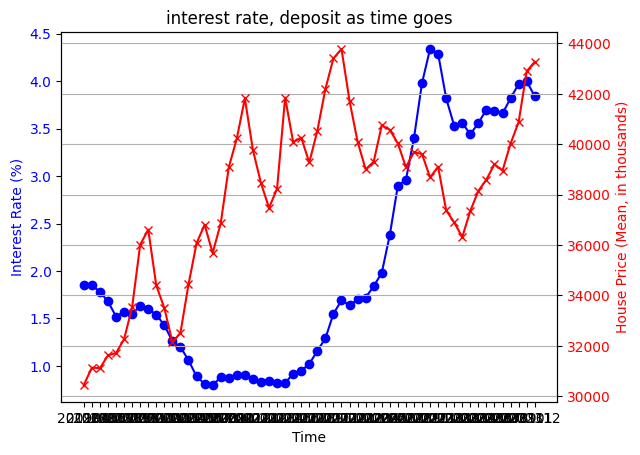

In [22]:
time = train_data['contract_year_month'].drop_duplicates().sort_values().astype(str)
rate = train_data.groupby('contract_year_month')['interest_rate'].mean()
deposit = train_data.groupby('contract_year_month')['deposit'].mean()

# 꺾은선 그래프 그리기
# 그래프 그리기
fig, ax1 = plt.subplots()

# 첫 번째 y축 - 금리
ax1.plot(time, rate, 'b-', marker='o', label='Interest Rate')
ax1.set_xlabel('Time')
ax1.set_ylabel('Interest Rate (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 - 집값
ax2 = ax1.twinx()  
ax2.plot(time, deposit, 'r-', marker='x', label='House Price (Mean)')
ax2.set_ylabel('House Price (Mean, in thousands)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('interest rate, deposit as time goes')
plt.grid(True)
plt.show()

In [8]:
pd.set_option('display.float_format', '{:.6f}'.format)
train_data[['latitude', 'longitude']].describe()

,latitude,longitude
count,1801228.000000,1801228.000000
mean,37.477208,126.966233
std,0.162511,0.170122
min,36.917910,126.478708
25%,37.379762,126.842159
50%,37.502270,126.997594
75%,37.582054,127.088811
max,38.181937,127.660896


In [9]:
pd.set_option('display.float_format', '{:.6f}'.format)
train_data[['deposit']].describe()

,deposit
count,1801228.000000
mean,38162.229423
std,26103.774198
min,300.000000
25%,21000.000000
50%,32000.000000
75%,47800.000000
max,1100000.000000


위도, 경도를 축으로 공공시설 분포 확인
초록색, 노랑색, 주황색, 빨강색 순서대로 deposit이 올라간다.

/data/ephemeral/home/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


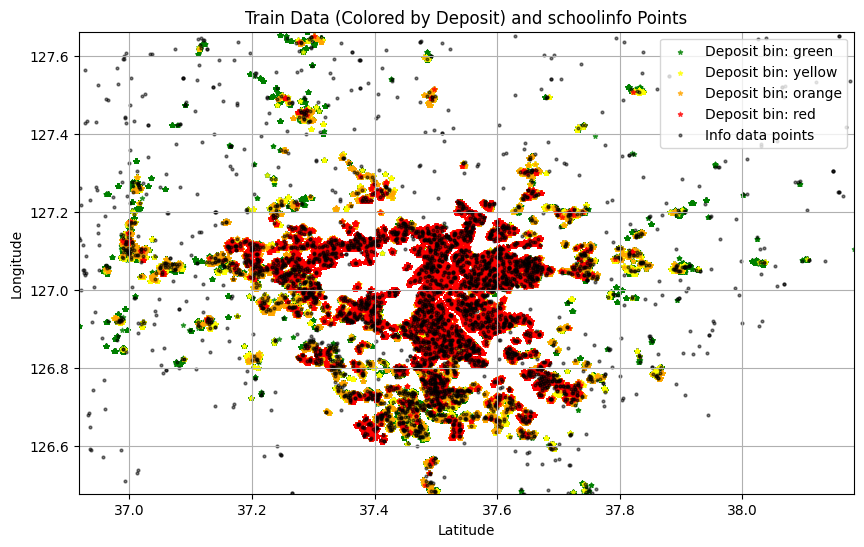

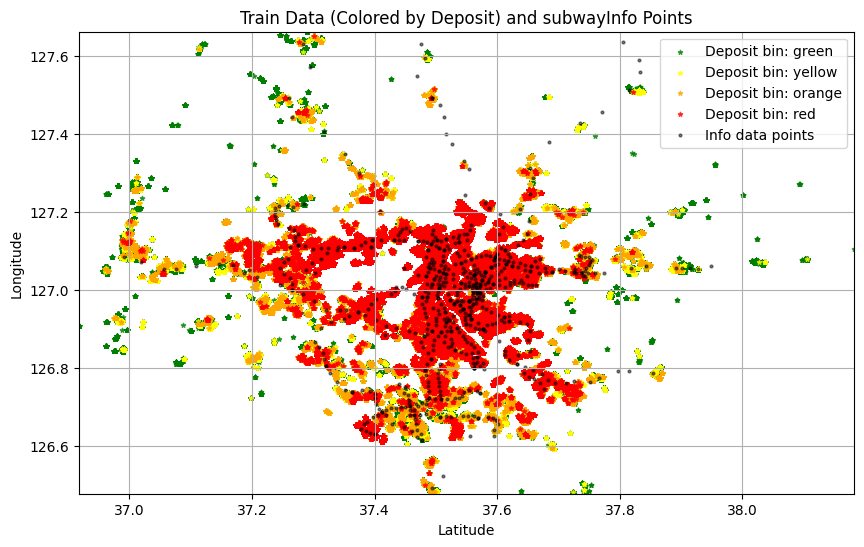

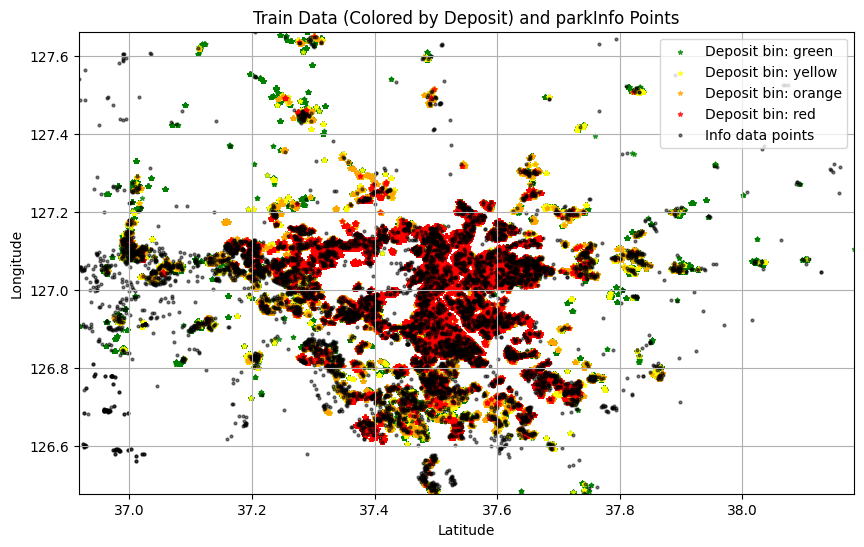

In [10]:
deposit_bin = [0,20000,30000,47800,np.inf]
colors = ['green', 'yellow', 'orange', 'red']
train_data['color'] = pd.cut(train_data['deposit'], bins = deposit_bin, labels=colors)

for name, info_data in file_dict.items():
    plt.figure(figsize=(10, 6))

    for color in colors:
        subset = train_data[train_data['color'] == color]
        plt.scatter(subset['latitude'], subset['longitude'], color=color, marker='*',label=f'Deposit bin: {color}', alpha=0.7, s=10)
    plt.xlim(train_data['latitude'].min(), train_data['latitude'].max())
    plt.ylim(train_data['longitude'].min(), train_data['longitude'].max())

    plt.scatter(info_data['latitude'], info_data['longitude'], color='black', label='Info data points', alpha = 0.5, s = 4)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(f'Train Data (Colored by Deposit) and {name} Points')
    plt.legend()
    plt.grid(True)
    plt.show()

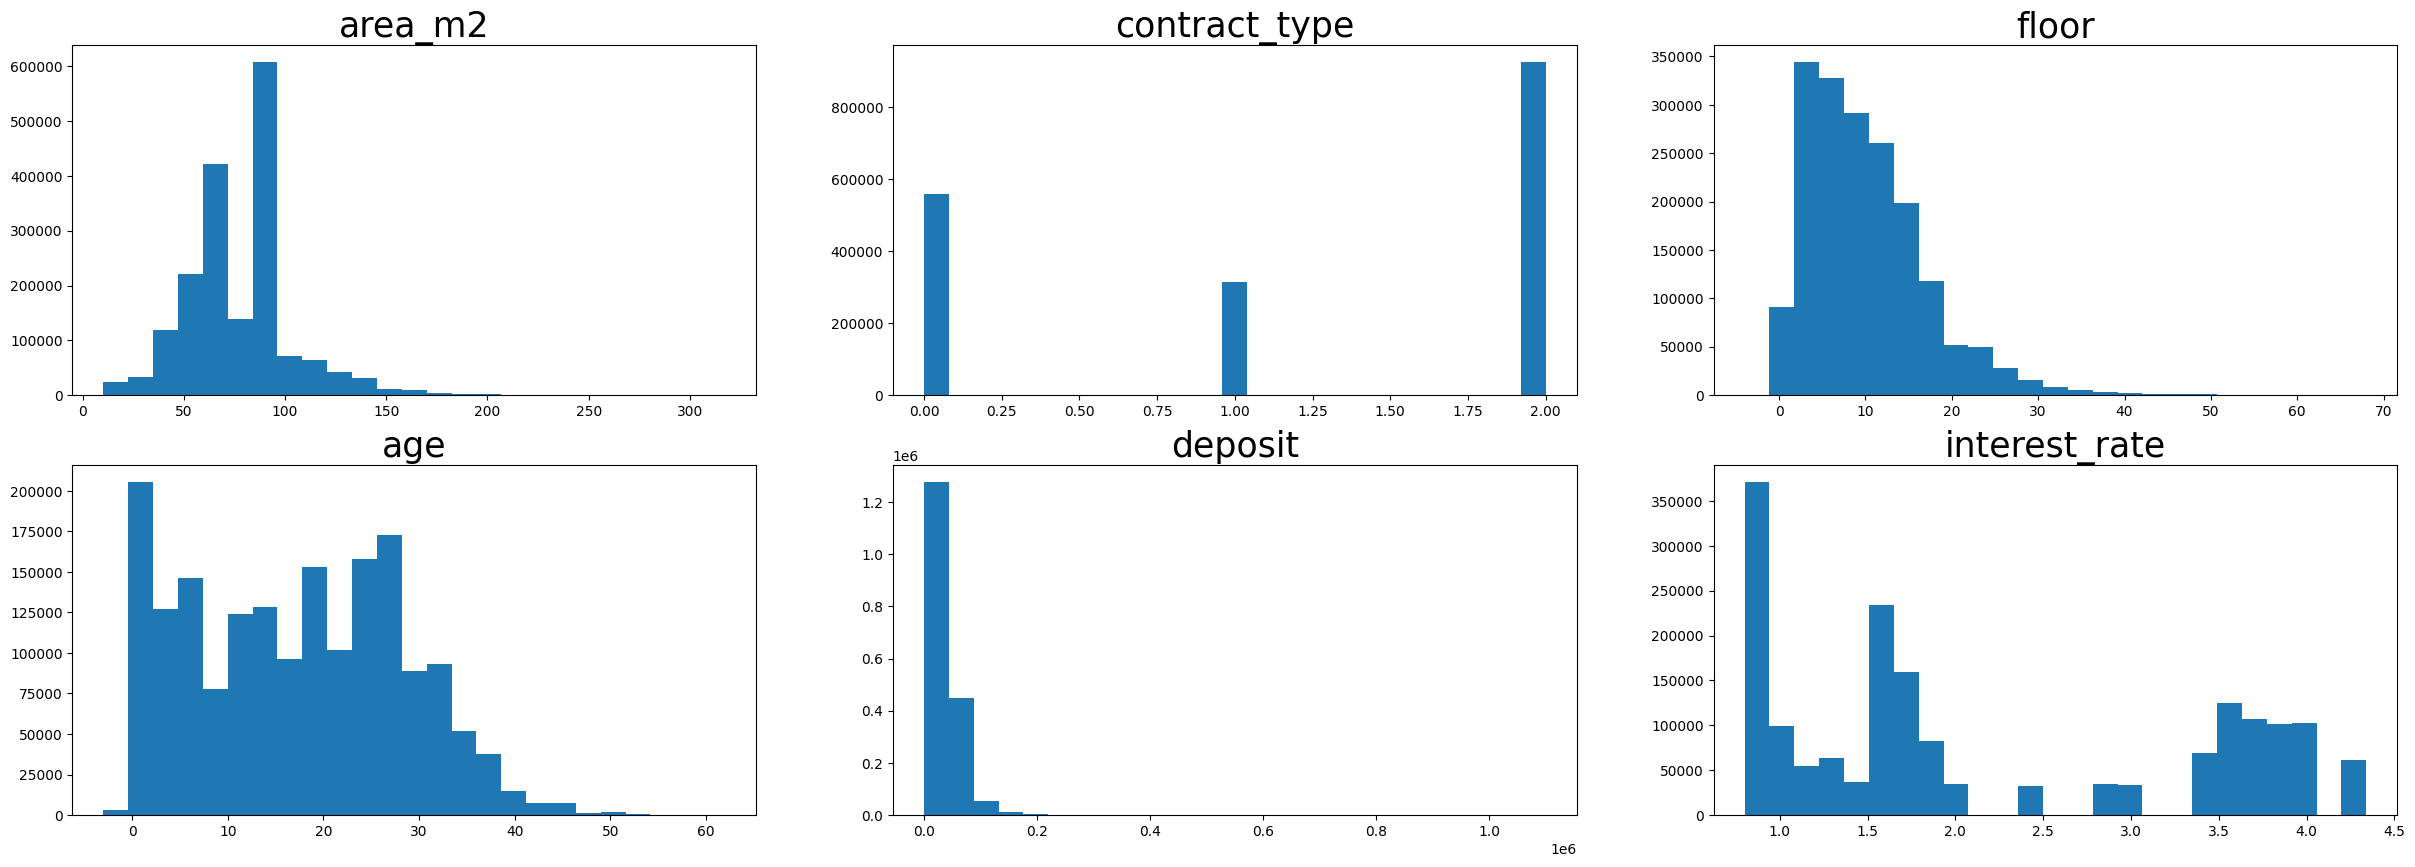

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
axes = axes.flatten()

for i, column in enumerate(train_data[['area_m2', 'contract_type','floor','age','deposit', 'interest_rate']].columns):
    axes[i].hist(train_data[column], bins=25)
    axes[i].set_title(column, fontsize=25)

## Clustering

### DBSCAN

<Axes: xlabel='latitude', ylabel='longitude'>

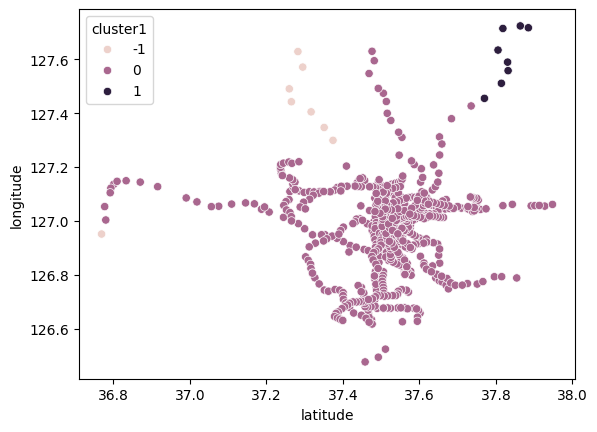

In [48]:
from sklearn.cluster import DBSCAN

subway_df = file_dict['subwayInfo']
#points = subway_df.as_matrix(columns=['latitude', 'longitude'])
subway_cluster = pd.DataFrame(DBSCAN(eps=0.1, min_samples=4).fit_predict(subway_df))
subway_cluster.columns=['cluster1']

subway_df = pd.concat([subway_df, subway_cluster], axis=1)

sns.scatterplot(subway_df, x='latitude', y='longitude', hue='cluster1')

### K-Means

schoolinfo


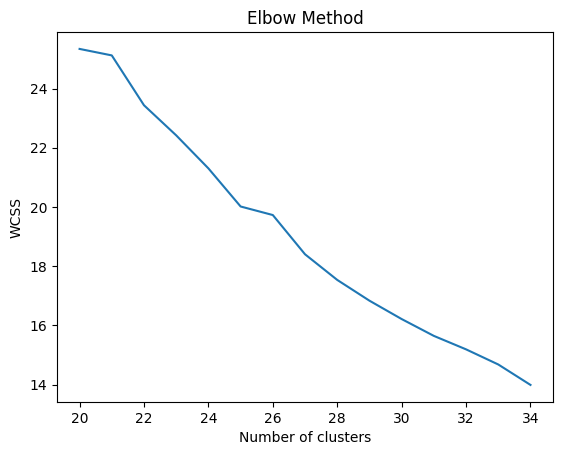

subwayInfo


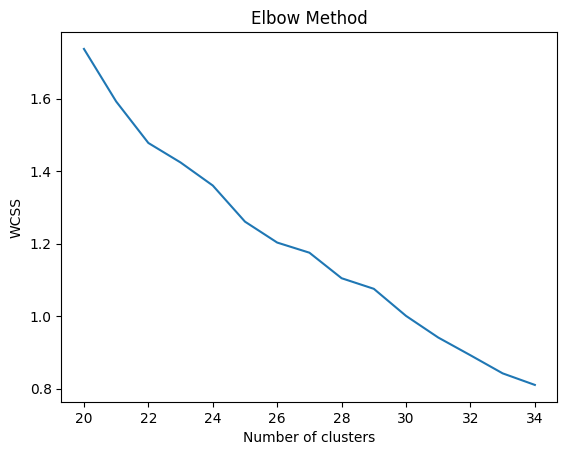

parkInfo


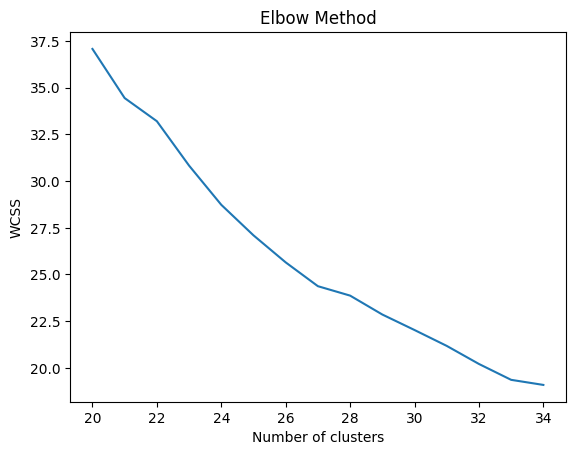

In [12]:
from sklearn.cluster import KMeans
k_range = range(20,35)
for i,v in file_dict.items():
    df = v.copy()
    inertias = []
    print(i)
    for k in k_range:
        Kmeans = KMeans(n_clusters = k, random_state=42)
        Kmeans.fit(df[['longitude', 'latitude']].values)
        inertias.append(Kmeans.inertia_)

    plt.plot(k_range, inertias)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [13]:
X_total = total_data[['longitude', 'latitude']].values

cluster를 범주형 피처로 변경하기

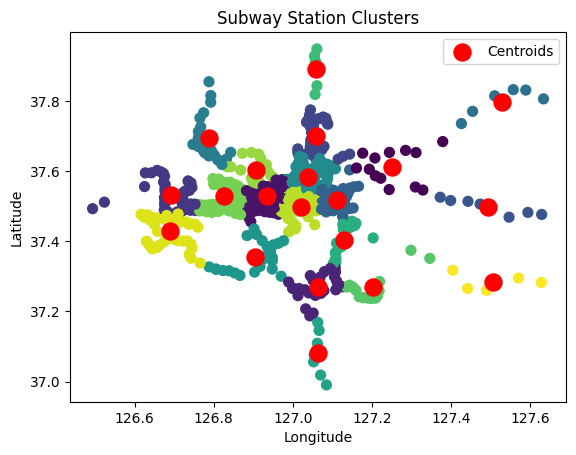

In [15]:
# 경도와 위도 데이터 추출
subway_df = file_dict['subwayInfo']
X_1 = subway_df[['longitude', 'latitude']].values

kmeans1 = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans1.fit(X_1)

plt.scatter(X_1[:, 0], X_1[:, 1], c=kmeans1.labels_, s=50, cmap='viridis')
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=150, c='red', label='Centroids')
plt.title('Subway Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

clusters1 = kmeans1.predict(X_total)
total_data['subwayCluster'] = pd.DataFrame(clusters1, dtype=object)

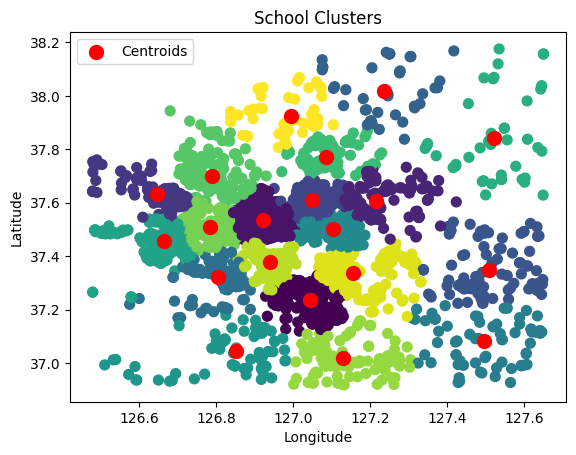

In [16]:
# 경도와 위도 데이터 추출
school_df = file_dict['schoolinfo']
X_2 = school_df[['longitude', 'latitude']].values

kmeans2 = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans2.fit(X_2)

plt.scatter(X_2[:, 0], X_2[:, 1], c=kmeans2.labels_, s=50, cmap='viridis')
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=100, c='red', label='Centroids')
plt.title('School Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

clusters2 = kmeans2.predict(X_total)
total_data['schoolCluster'] = pd.DataFrame(clusters2, dtype=object)

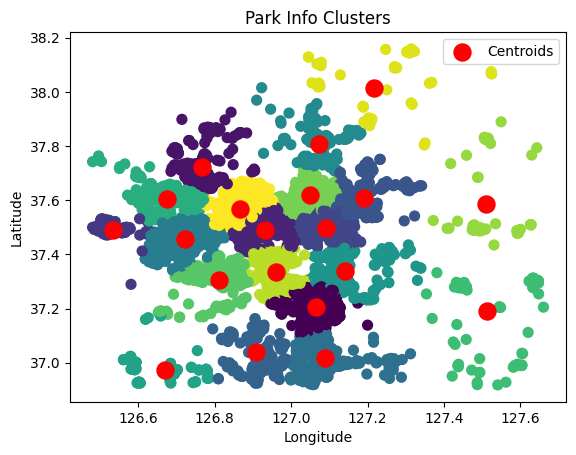

In [17]:
# 경도와 위도 데이터 추출
park_df = file_dict['parkInfo']
X_3 = park_df[['longitude', 'latitude']].values

kmeans3 = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans3.fit(X_3)

plt.scatter(X_3[:, 0], X_3[:, 1], c=kmeans3.labels_, s=50, cmap='viridis')
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], s=150, c='red', label='Centroids')
plt.title('Park Info Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

clusters3 = kmeans3.predict(X_total)
total_data['parkCluster'] = pd.DataFrame(clusters3, dtype=object)

In [71]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717611 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   area_m2              float64
 1   contract_year_month  int64  
 2   contract_day         int64  
 3   contract_type        int64  
 4   floor                int64  
 5   latitude             float64
 6   longitude            float64
 7   subwayCluster        int32  
 8   schoolCluster        int32  
 9   parkCluster          int32  
 10  deposit              float64
dtypes: float64(4), int32(3), int64(4)
memory usage: 202.1 MB


In [19]:
X_train = total_data[total_data['deposit'].notna()]
X_test = total_data[total_data['deposit'].isna()]
print(X_train.shape, X_test.shape)

(1801228, 14) (150172, 14)


## LightGBM prediction

In [20]:
# train data에서 중복 제거
X_train.drop_duplicates(subset=['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'age', 'deposit'], inplace = True)

#필요한 column만 추출
needed_columns = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'subwayCluster', 'schoolCluster', 'parkCluster', 'deposit']
needed_columns_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'subwayCluster', 'schoolCluster', 'parkCluster']

X_train = X_train[needed_columns]
test_data = X_test[needed_columns_test]

/tmp/ipykernel_83814/3706876057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop_duplicates(subset=['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'age', 'deposit'], inplace = True)


In [34]:
import numpy as np

# 이상치 제거 함수
def remove_outlier(df, columns, weight = 1.5):
# IQR * weight에서 weight의 default를 1.5로 지정
  
  new_df = df.copy()
  for column in columns:
    fraud = new_df[column]
    Q1 = np.percentile(fraud.values, 10)
    Q1 = 0

    Q3 = np.percentile(fraud.values, 90)
    # 3사분위수(Q3) => 90으로 설정

    iqr = Q3 - Q1
    iqr_weight = iqr * weight
    print(iqr, iqr_weight)

    lowest_val = Q1 - iqr_weight
    # 최솟값
    highest_val = Q3 + iqr_weight
    # 최댓값
    print(lowest_val, highest_val)

    low_outlier_index = fraud[(fraud < lowest_val)].index
    high_outlier_index = fraud[(fraud > highest_val)].index
    
    # 최솟값보다 작고, 최댓값보다 큰 이상치 데이터들의 인덱스
    new_df.loc[low_outlier_index,column] = lowest_val
    new_df.loc[high_outlier_index,column] = highest_val
    
    # 전체 데이터에서 이상치 데이터 제거
    new_df.reset_index(drop = True, inplace = True)

  return new_df

total_data = pd.concat([train_data, holdout_data], axis=0)

remove_outlier_df = remove_outlier(total_data, ["area_m2", "deposit"])
print(f"이상치 제거 후: {remove_outlier_df.area_m2.min(), remove_outlier_df.area_m2.max()}")

104.41 156.615
-156.615 261.025
68000.0 102000.0
-102000.0 170000.0
이상치 제거 후: (10.3215, 261.025)


In [38]:
X_train = remove_outlier_df.copy()

In [57]:
# train, valid data로 분리
holdout_start = 202307
holdout_end = 202312
holdout_data = X_train[(X_train['contract_year_month'] >= holdout_start) & (X_train['contract_year_month'] <= holdout_end)]
train_data = X_train[~((X_train['contract_year_month'] >= holdout_start) & (X_train['contract_year_month'] <= holdout_end))]

In [ ]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

In [67]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
modules.mae_to_csv(lgb_holdout_mae, 'clustering+lgbm+outlier')

print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 2114883, number of used features: 10
[LightGBM] [Info] Start training from score 38519.654035
Holdout 데이터셋 성능:
LightGBM MAE: 7134.05


In [68]:
# 전체 데이터셋으로 학습

X_train = pd.concat([X_train, X_holdout])
y_train = pd.concat([y_train, y_holdout])

lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

lgb_test_pred = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 2313519, number of used features: 10
[LightGBM] [Info] Start training from score 38698.189237


In [69]:
import utils.modules as modules
sample_submission['deposit'] = lgb_test_pred
modules.submission_to_csv(sample_submission, 'clustering+lgbm+outlier')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

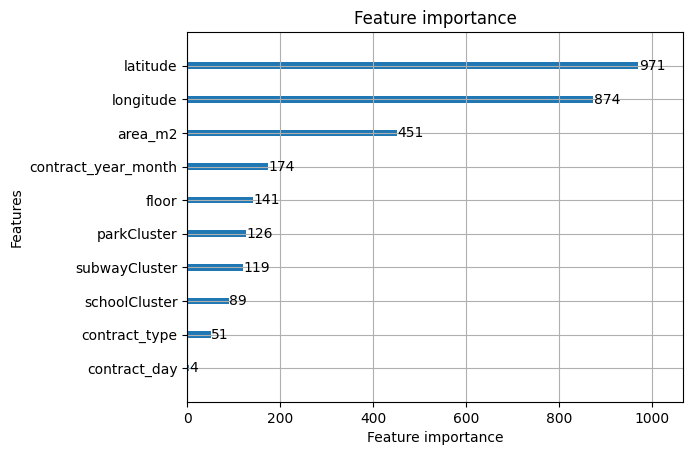

In [70]:
lgb.plot_importance(lgb_model)